In [55]:
from rdchiral.template_extractor import extract_from_reaction
import polars as pl
from hydra import initialize, compose
from pathlib import Path
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from DORA_XGB.DORA_XGB import feasibility_classifier
from ast import literal_eval

In [3]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    fps = compose(config_name="filepaths")

In [76]:
rxn_metrics = pl.read_parquet(
    Path(fps.processed_data) / "2_steps_250728_benchmark_starters_rules_mechinferred_dt_04_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet"
)
rxn_metrics = rxn_metrics.explode("rules").with_columns(
    pl.col("rules").map_elements( lambda x: x.split('_')[0], return_dtype=pl.String ) 
)
rxn_metrics.head()

id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion
str,str,str,i64,f64,str,str,str,str
"""Rdfa93f07103aae10824d509d68aee…","""NC(N)=NCCCC(N)C(=O)O.NC(N)=NCC…","""[NH2:1][C:2]([NH2:3])=[N:4][CH…",1,0.75,"""N=C(N)NCCCC(N)C(=O)O.*C(=O)C(*…","""40d495b06562cc98f426f0a38a7ecd…","""1838""","""2_steps_250728_benchmark_start…"
"""Rdfa93f07103aae10824d509d68aee…","""NC(N)=NCCCC(N)C(=O)O.NC(N)=NCC…","""[NH2:1][C:2]([NH2:3])=[N:4][CH…",1,0.75,"""N=C(N)NCCCC(N)C(=O)O.*C(=O)C(*…","""40d495b06562cc98f426f0a38a7ecd…","""1838""","""2_steps_250728_benchmark_start…"
"""Rdfa93f07103aae10824d509d68aee…","""NC(N)=NCCCC(N)C(=O)O.NC(N)=NCC…","""[NH2:1][C:2]([NH2:3])=[N:4][CH…",1,0.75,"""N=C(N)NCCCC(N)C(=O)O.*C(=O)C(*…","""40d495b06562cc98f426f0a38a7ecd…","""1838""","""2_steps_250728_benchmark_start…"
"""R27e0413e700ccbc850256ce9614b6…","""O=C(O)CCC(=O)O.N>>NC(=O)CCC(=O…","""[O:1]=[C:2]([OH:3])[CH2:4][CH2…",0,0.833333,"""*C(=O)C(N)CCC(=O)O.N>>*C(=O)C(…","""152c0a36dafafe0eca20ea33eb677d…","""4838""","""2_steps_250728_benchmark_start…"
"""R27e0413e700ccbc850256ce9614b6…","""O=C(O)CCC(=O)O.N>>NC(=O)CCC(=O…","""[O:1]=[C:2]([OH:3])[CH2:4][CH2…",0,0.833333,"""*C(=O)C(N)CCC(=O)O.N>>*C(=O)C(…","""152c0a36dafafe0eca20ea33eb677d…","""39""","""2_steps_250728_benchmark_start…"


In [16]:
rule_feas = rxn_metrics.group_by("rules").agg(
    pl.col("dxgb_label").mean().alias("mean_feasibility"),
    pl.col("max_rxn_sim").mean().alias("mean_max_rxn_sim"),
    pl.len().alias("n_rxns")
).sort(by=["mean_feasibility", 'n_rxns'], descending=False)
rule_feas.head()

rules,mean_feasibility,mean_max_rxn_sim,n_rxns
str,f64,f64,u32
"""251""",0.0,0.486864,1
"""64""",0.0,1.0,1
"""425""",0.0,0.40032,1
"""385""",0.0,0.627182,1
"""450""",0.0,0.609272,1


In [64]:
rule_feas.filter((pl.col("n_rxns") > 100) & (pl.col("mean_feasibility") < 0.01)).sort("n_rxns", descending=True)

rules,mean_feasibility,mean_max_rxn_sim,n_rxns
str,f64,f64,u32
"""876""",0.003442,0.714106,2324
"""216""",0.009631,0.837709,623
"""177""",0.0,0.942171,536
"""118""",0.0,0.530707,384
"""581""",0.0,0.857866,339
…,…,…,…
"""138""",0.0,0.346822,195
"""600""",0.0,0.76242,132
"""870""",0.0,0.800328,130


In [31]:
rule_feas.filter((pl.col("n_rxns") > 100) & (pl.col("mean_feasibility") > 0.9)).sort("n_rxns", descending=True)

rules,mean_feasibility,mean_max_rxn_sim,n_rxns
str,f64,f64,u32
"""166""",0.961268,0.565888,284
"""585""",0.945455,0.836504,165
"""595""",1.0,0.849273,112


In [67]:
rule_feas.filter((pl.col("n_rxns") > 100) & (pl.col("mean_feasibility") < 0.1)).sort("n_rxns", descending=True)['n_rxns'][:100].sum()

19045

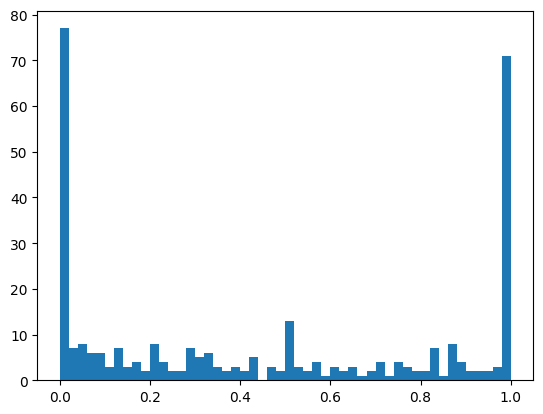

In [27]:
plt.hist(rule_feas['mean_feasibility'], bins=50)
plt.show()

In [57]:
mechinfo_rules = pl.read_csv(
    Path(fps.processed_data) / "mechinformed_rules.csv"
)
mechinfo_rules = mechinfo_rules.with_columns(
    pl.col("entry_id").map_elements(lambda x : literal_eval(x), return_dtype=pl.List(pl.Int64))
).explode('entry_id')
mechinfo_rules.head()

id,smarts,entry_id,mechanism_id
i64,str,i64,str
0,"""[C&D3&v4&H1&+0&!R&z1:1]-[C&D3&…",1,"""[1, 1]"""
0,"""[C&D3&v4&H1&+0&!R&z1:1]-[C&D3&…",1,"""[1, 1]"""
1,"""[C&D3&v4&H0&+0&R&z2:1](=[O&D1&…",2,"""[2, 1, 1, 1, 1]"""
1,"""[C&D3&v4&H0&+0&R&z2:1](=[O&D1&…",2,"""[2, 1, 1, 1, 1]"""
1,"""[C&D3&v4&H0&+0&R&z2:1](=[O&D1&…",210,"""[2, 1, 1, 1, 1]"""


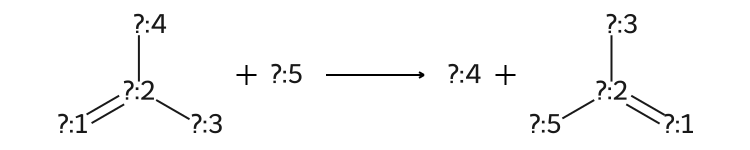

In [69]:
AllChem.ReactionFromSmarts(mechinfo_rules.filter(pl.col("id") == 70)['smarts'][0])

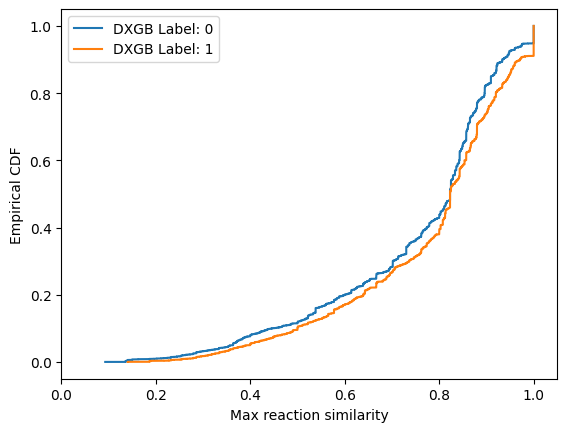

In [77]:
fig, ax = plt.subplots()
for i in [0, 1]:
    _data = rxn_metrics.filter(pl.col("dxgb_label") == i)['max_rxn_sim'].to_numpy()
    ycdf = np.arange(1, len(_data) + 1) / len(_data)
    sx = np.sort(_data)
    ax.step(sx, ycdf, where="post", label=f"DXGB Label: {i}")
ax.set_xlabel("Max reaction similarity")
ax.set_ylabel("Empirical CDF")
ax.set_xlim(0, 1.05)
ax.legend()
plt.show()

In [40]:
krs = pl.read_parquet(
    Path(fps.raw_data) / "known_reactions.parquet"
)
clf = feasibility_classifier(cofactor_positioning='add_concat')
krs.head()

id,smarts,enzymes,reverse,db_ids
str,str,list[str],str,list[str]
"""e908a824c912d1e39c46de92d1f738…","""**.NC(CCC(=O)NC(CS)C(=O)NCC(=O…","[""P30109"", ""P57108"", … ""P46436""]","""3bbe8e6dca0da1c745e7678c8efebe…","[""RHEA:16438""]"
"""d86d99a8143d3be8fc861a5de5e625…","""*.*.*.*.*.*.*.*.*.*.CC(C)(COP(…","[""Q0UK48"", ""A0A0C6E0I7"", … ""A0A0C6DWS6""]","""e99fb0b75e799eba72aee21c1d04ee…","[""RHEA:51350""]"
"""2972b2db66715ba6f3d6aeaf07f31b…","""*.*.*.*.*.*.*.*.*NC(COP(=O)(O)…","[""G0REX6"", ""P0DO30"", ""A0A482N9V7""]","""5a7fffef224c65b7cd431ddc668eb2…","[""RHEA:64546""]"
"""572e4a84a946af07c9ab6fd1c0347b…","""*.*.*.*.*.*.*.*.*OP(=O)(O)OCC(…","[""Q6M083"", ""Q8U4J0"", … ""C5A6E5""]","""c4c936d8d985a457a128601b8d2769…","[""RHEA:64377""]"
"""dfe7fc761de3c213bf2b18fae4f8a5…","""*.*.*.*.*.*.*.*.CC(C)CCCC(C)CC…","[""Q6M083"", ""Q8U4J0"", … ""C5A6E5""]","""2e026380a550baa6b343604e6f5500…","[""RHEA:64369""]"


In [ ]:
krs = krs.with_columns(
    pl.col("smarts").map_elements(lambda x: clf.predict_label(x), return_dtype=pl.Int32).alias("dxgb_label")
)

In [53]:
krs['smarts'].mean()

0.5281429891265724

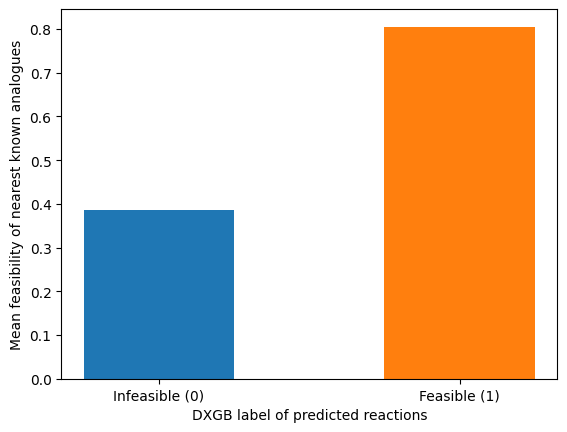

In [78]:
fig, ax = plt.subplots()
for i in [0, 1]:
    mask = rxn_metrics.filter(pl.col("dxgb_label") == i)['nearest_analogue_id'].to_list()
    _data = krs.filter(pl.col("id").is_in(mask))['smarts'].mean()

    ax.bar(i, _data, width=0.5)
ax.set_xlabel("DXGB label of predicted reactions")
ax.set_ylabel("Mean feasibility of nearest known analogues")
ax.set_xticks([0, 1], labels=["Infeasible (0)", "Feasible (1)"])
plt.show()